In [3]:
# !wget 'https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip'

In [4]:
# !unzip '/content/dataset-resized.zip'

In [1]:
# !pip install fastai --upgrade

In [2]:
import fastai
fastai.__version__

'2.0.16'

In [3]:
from fastai.vision.all import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [5]:
# os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

In [4]:
## helper functions ##
## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [6]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [7]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

Path('/content/data')

In [32]:
fns = get_image_files(path)
fns

(#1892) [Path('/content/data/valid/trash/trash61.jpg'),Path('/content/data/valid/trash/trash94.jpg'),Path('/content/data/valid/trash/trash9.jpg'),Path('/content/data/valid/trash/trash104.jpg'),Path('/content/data/valid/trash/trash46.jpg'),Path('/content/data/valid/trash/trash131.jpg'),Path('/content/data/valid/trash/trash101.jpg'),Path('/content/data/valid/trash/trash82.jpg'),Path('/content/data/valid/trash/trash69.jpg'),Path('/content/data/valid/trash/trash33.jpg')...]

In [33]:
# tfms = get_transforms(do_flip=True,flip_vert=True)
# data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=64)

In [34]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224))

In [35]:
dls = data.dataloaders(path)

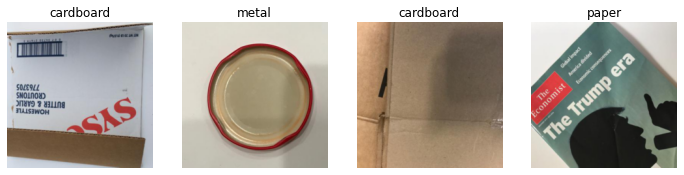

In [36]:
dls.valid.show_batch(max_n=4, nrows=1)

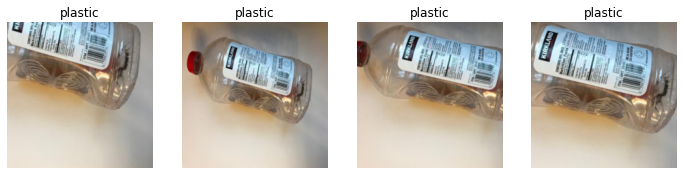

In [37]:
data = data.new(item_tfms=RandomResizedCrop(224, min_scale=0.3))
dls = data.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

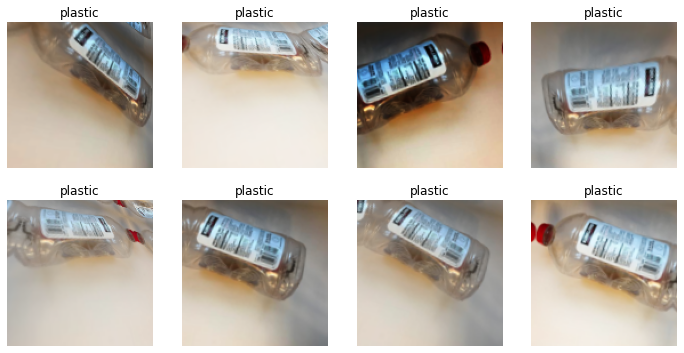

In [41]:
# learn.lr_find()
# learn.recorder.plot()
data = data.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = data.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [43]:
# learn.fit_one_cycle(20,max_lr=slice(1e-4,1e-3))
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,2.123910,0.956022,0.291005,00:08


epoch,train_loss,valid_loss,error_rate,time
0,1.138276,0.864518,0.269841,00:08
1,1.015965,0.780661,0.243386,00:08
2,0.851408,0.994813,0.238095,00:08
3,0.727640,0.930272,0.219577,00:08
4,0.599126,0.759907,0.187831,00:08
5,0.505123,0.670172,0.171958,00:08
6,0.413110,0.637073,0.156085,00:08
7,0.339910,0.628888,0.153439,00:08
8,0.294373,0.626295,0.156085,00:08
9,0.265980,0.609851,0.158730,00:08


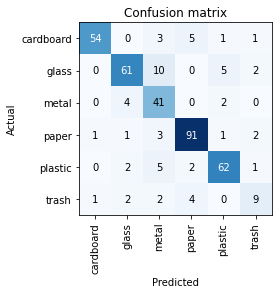

In [44]:
# interp = ClassificationInterpretation.from_learner(learn)
# losses,idxs = interp.top_losses()

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [45]:
# interp.plot_top_losses(9, figsize=(15,11))
learn.export()

In [47]:
# doc(interp.plot_top_losses)
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
learn_inf = load_learner('/content/export.pkl') 

In [18]:
# interp.most_confused(min_val=2)

In [48]:
!wget 'https://5.imimg.com/data5/HG/DI/MY-3889281/white-art-paper-500x500.jpg' 

--2020-10-29 09:32:22--  https://5.imimg.com/data5/HG/DI/MY-3889281/white-art-paper-500x500.jpg
Resolving 5.imimg.com (5.imimg.com)... 13.224.11.91, 13.224.11.76, 13.224.11.17, ...
Connecting to 5.imimg.com (5.imimg.com)|13.224.11.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13976 (14K) [image/jpg]
Saving to: ‘white-art-paper-500x500.jpg’

white-art-paper-500 100%[===================>]  13.65K  --.-KB/s    in 0.03s   

2020-10-29 09:32:23 (466 KB/s) - ‘white-art-paper-500x500.jpg’ saved [13976/13976]



In [51]:
# img = open_image('/content/white-art-paper-500x500.jpg')
# img

learn_inf.predict('/content/white-art-paper-500x500.jpg')

('cardboard',
 tensor(0),
 tensor([9.1236e-01, 1.0402e-04, 9.4772e-05, 8.6855e-02, 3.7299e-05, 5.5363e-04]))

In [52]:
# def model_from_drive():
#   model = load_learner(Path('/content/drive/My Drive/Classroom/')/'model.pkl')
#   return model

In [53]:
# model = model_from_drive()

In [54]:
!pip install ipywidgets
# !pip install fastai --upgrade

In [55]:
#hide_output
import ipywidgets  as widgets
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [72]:
img = PILImage.create(btn_upload.data[-1])

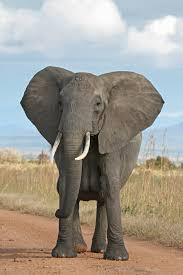

In [73]:
img

In [74]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [75]:
pred,pred_idx,probs = learn_inf.predict(img)

In [76]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: trash; Probability: 0.6416')

In [66]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run


Button(description='Classify', style=ButtonStyle())

In [77]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(224,224))
    
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [78]:
btn_upload = widgets.FileUpload()

In [79]:
from IPython.display import display

In [80]:
#hide_output
widgets.VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [81]:
!pip install voila
!jupyter serverextension enable voila —sys-prefix

     |████████████████████████████████| 1.9MB 2.6MB/s 
     |████████████████████████████████| 112kB 29.8MB/s 
     |████████████████████████████████| 552kB 22.3MB/s 
     |████████████████████████████████| 204kB 30.7MB/s 
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1


Enabling: voila
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
Enabling: —sys-prefix
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension —sys-prefix
      X is —sys-prefix importable?


In [13]:
# import shutil
# shutil.copy('/content/dataset-resized.pth','/content/drive/My Drive/Classroom')

In [14]:
# from flask import Flask

In [ ]:
app = Flask(__name__)

@app.route('/')
def hello_world():
    return 'Hello, World!'



In [ ]:
!flask run

 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
Usage: flask run [OPTIONS]

Error: Could not locate a Flask application. You did not provide the "FLASK_APP" environment variable, and a "wsgi.py" or "app.py" module was not found in the current directory.


In [12]:
!pip install flask-ngrok

In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask,render_template,redirect, flash, url_for,request
import urllib.request
from werkzeug.utils import secure_filename

app = Flask(__name__)
run_with_ngrok(app)   #starts ngrok when the app is run
@app.route('/')
def index():
    return render_template('index.html')


@app.route('/', methods=['POST'])
def submit_file():
    if request.method == 'POST':
      if 'file' not in request.files:
        flash('No file part')
        return redirect(request.url)
      file = request.files['file']
      if file.filename == '':
        flash('No file selected for uploading')
        return redirect(request.url)
      if file:
        print("hello this is")
        filename = secure_filename(file.filename)
        # file.save(os.path.join(app.config['UPLOAD_FOLDER'],filename))
        preds = model(filename)
        # label, acc = getPrediction(filename)
        flash(label)
        # flash(acc)
        flash(filename)
        return redirect('/')
app.run()

In [9]:
HTML_TEMPLATE = """
<!doctype html>
<title>Flask & VGG16 Image Classifier</title>
<h2>Select a file to upload</h2>
<p>
	{% with messages = get_flashed_messages() %}
	  {% if messages %}
        Label: {{ messages[0] }}
        Accuracy: {{ messages[1] }}
	  {% endif %}
	{% endwith %}
</p>
<form method="post" action="/" enctype="multipart/form-data">
    <dl>
	<p>
		<input type="file" name="file" autocomplete="off" required>
	</p>
    </dl>
    <p>
	<input type="submit" value="Submit">
    </p>
</form>
"""



filename = ('index.html')
print(filename)
savePath = "/content/"+'/'+filename

saveData = (HTML_TEMPLATE.replace("%s", "Namaste"))

template_save = open(savePath, "w")
template_save.write(saveData)
template_save.close()


index.html


In [8]:
!mkdir "templates"

In [47]:
# learn.load('/content/drive/My Drive/Classroom/dataset-resized')

In [13]:
model = load_learner('/content/drive/My Drive/Classroom', 'model.pkl')